# Wykrywanie anomalii - zaburzeń rytmu pracy serca

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import normalize
import random
import os

In [39]:
get_ipython().magic('matplotlib inline')
os.chdir('/home/sas/Zasoby/Python/Anomalie')
df = pd.read_csv('ecg_discord_test.csv', sep=',', header=None)
df.shape
X_train = df[:20]
X_test = df[:23]
scaled_X = normalize(X_train)

In [40]:
def ekg_chart(X):
    X = pd.DataFrame(X)
    plt.figure(figsize=(16, 4))
    for i in range(X.shape[0]):
        plt.plot(X.iloc[i],  lw=1)

Text(0.5,1,'Przebiegi wadliwe (trzy ostatnie w próbie) - widoczna różnica na tle przebiegów wzorcowych')

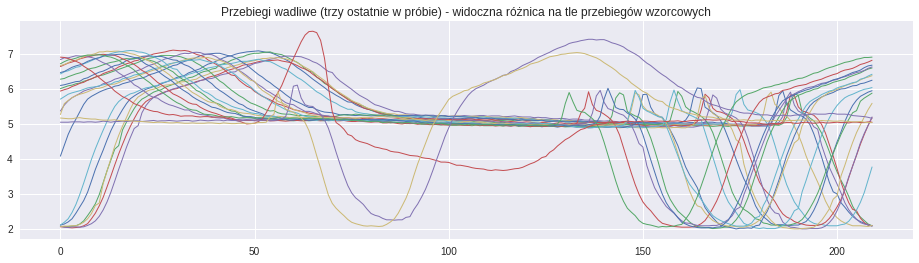

In [41]:
ekg_chart(X_test[:]); plt.title('Przebiegi wadliwe (trzy ostatnie w próbie) - widoczna różnica na tle przebiegów wzorcowych')

Autoenkoder

In [42]:
model = Sequential()
model.add(Dense(1, input_shape = (210,)))
model.add(Dense(60, activation = 'sigmoid'))
model.add(Dense(20, activation = 'sigmoid'))
model.add(Dense(2, activation = 'sigmoid'))
model.add(Dense(20, activation = 'sigmoid'))
model.add(Dense(60, activation = 'sigmoid'))
model.add(Dense(210, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])
model.fit(scaled_X, scaled_X,
          batch_size = 1,
          epochs = 50,
          validation_split = 0.25,
          verbose = False)

In [43]:
outp_test = model.predict(normalize(X_test[:]))
mse_test = ((normalize(X_test[:]) - outp_test)**2).mean(1)
mse = pd.core.series.Series(mse_test)

Text(0.5,1,'Wzorcowy przebieg odtworzony przez autoenkoder')

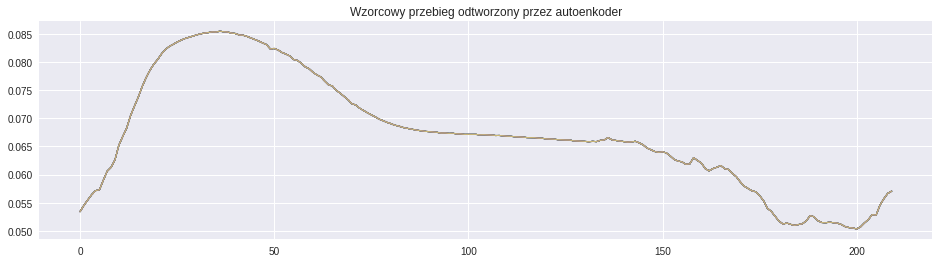

In [44]:
ekg_chart(outp_test); plt.title('Wzorcowy przebieg odtworzony przez autoenkoder')

Text(0.5,1,'Błąd rekonstrukcji (MSE)')

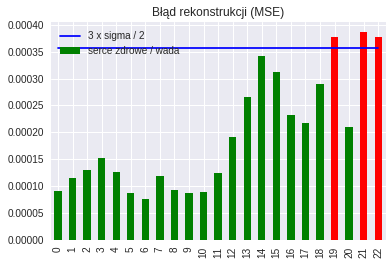

In [45]:
colors = [('r' if mse[i] > mse.mean() + 1.5 * mse.std() else 'g') for i in range(len(mse))]
mse.plot('bar', color=colors); plt.plot([(mse.mean() + 1.5 * mse.std())] * len(mse), 'b')
plt.legend(['3 x sigma / 2','serce zdrowe / wada'], loc='upper left'); plt.title('Błąd rekonstrukcji (MSE)')

- 19-ta i 20-ta próbka zakwalifikowana błędnie

Principal Component Analysis

In [46]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_test)
X_recovered = pca.inverse_transform(X_reduced)
mse = ((X_test - X_recovered)**2).mean(1)
pca.explained_variance_ratio_.sum()

0.69467847962972984

Text(0.5,1,'Wadliwe przebiegi po redukcji wymiarów')

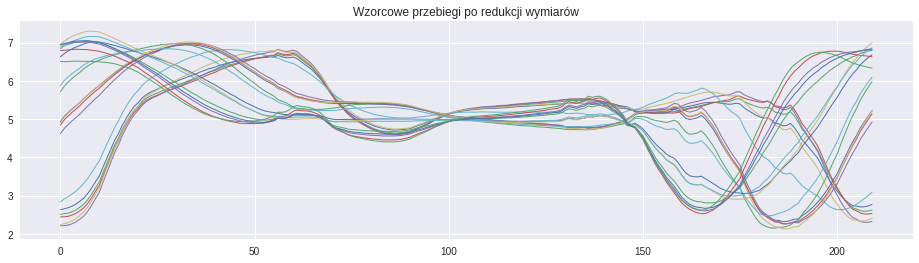

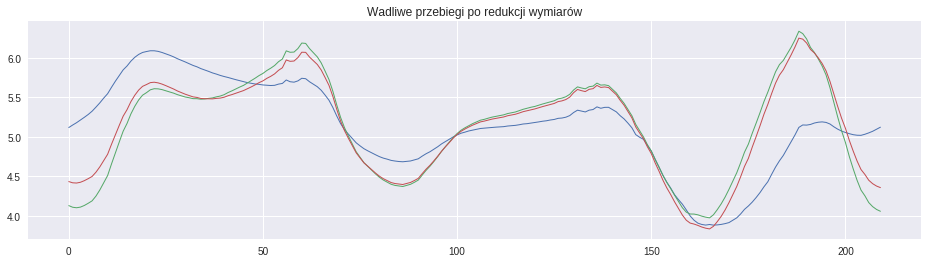

In [47]:
ekg_chart(X_recovered[:20]); plt.title('Wzorcowe przebiegi po redukcji wymiarów')
ekg_chart(X_recovered[20:]); plt.title('Wadliwe przebiegi po redukcji wymiarów')

Text(0.5,1,'Błąd rekonstrukcji (MSE)')

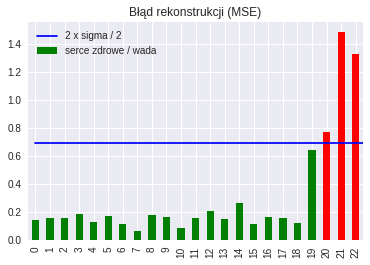

In [48]:
colors = [('r' if mse[i] > mse.mean() + 1.0 * mse.std() else 'g') for i in range(len(mse))]
mse.plot('bar', color=colors); plt.plot([(mse.mean() + 1.0 * mse.std())] * X_test.shape[1], 'b')
plt.legend(['2 x sigma / 2','serce zdrowe / wada'], loc='upper left'); plt.title('Błąd rekonstrukcji (MSE)')

- Wadliwe przebiegi zakwalifikowane prawidłowo

Metoda nieujemnych składowych

In [49]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=3)
X_reduced = nmf.fit_transform(X_test)
X_recovered = nmf.inverse_transform(X_reduced)
mse = ((X_test - X_recovered)**2).mean(1)

Text(0.5,1,'Wadliwe przebiegi po redukcji wymiarów')

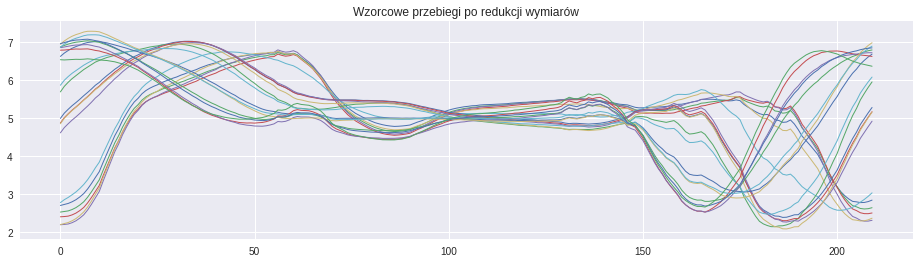

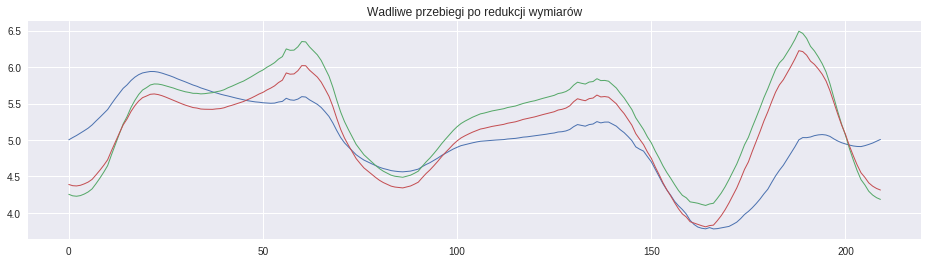

In [50]:
ekg_chart(X_recovered[:20]); plt.title('Wzorcowe przebiegi po redukcji wymiarów')
ekg_chart(X_recovered[20:]); plt.title('Wadliwe przebiegi po redukcji wymiarów')

Text(0.5,1,'Błąd rekonstrukcji (MSE)')

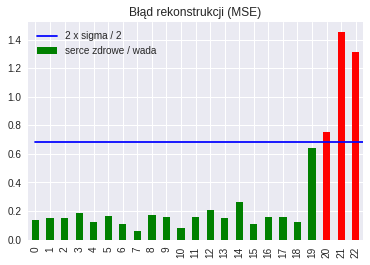

In [51]:
colors = [('r' if mse[i] > mse.mean() + 1.0 * mse.std() else 'g') for i in range(len(mse))]
mse.plot('bar', color=colors); plt.plot([(mse.mean() + 1.0 * mse.std())] * X_test.shape[1], 'b')
plt.legend(['2 x sigma / 2','serce zdrowe / wada'], loc='upper left'); plt.title('Błąd rekonstrukcji (MSE)')

Jądrowa (rbf) PCA 

In [52]:
from sklearn.decomposition import KernelPCA

kpca = KernelPCA(fit_inverse_transform=True, kernel='rbf', n_components=2)
X_reduced = kpca.fit_transform(X_test)
X_recovered = kpca.inverse_transform(X_reduced)
mse = ((X_test - X_recovered)**2).mean(1)

Text(0.5,1,'Wadliwe przebiegi po redukcji wymiarów')

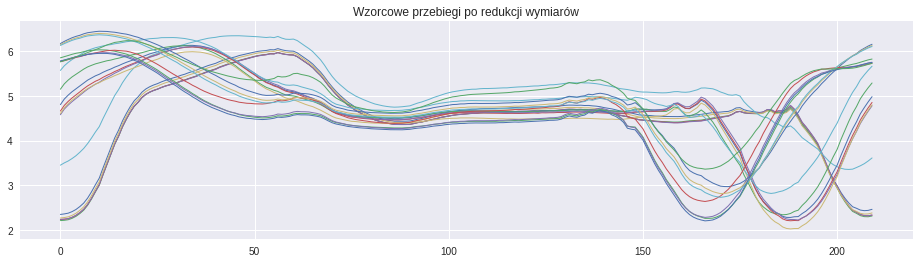

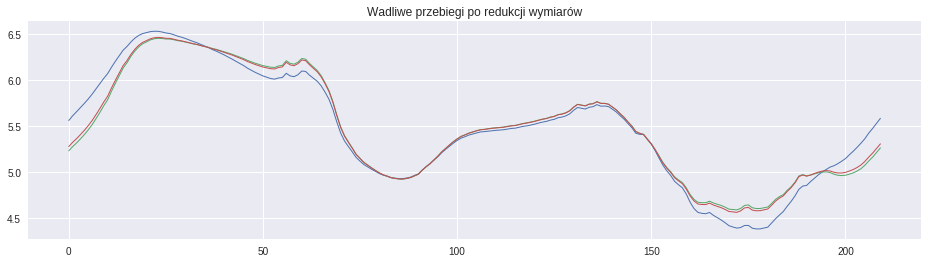

In [53]:
ekg_chart(X_recovered[:20]); plt.title('Wzorcowe przebiegi po redukcji wymiarów')
ekg_chart(X_recovered[20:]); plt.title('Wadliwe przebiegi po redukcji wymiarów')

Text(0.5,1,'Błąd rekonstrukcji (MSE)')

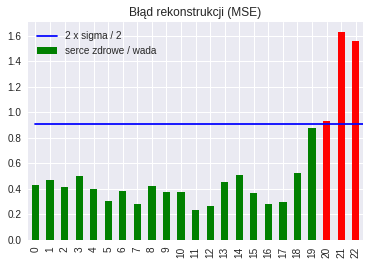

In [55]:
colors = [('r' if mse[i] > mse.mean() + 1.0 * mse.std() else 'g') for i in range(len(mse))]
mse.plot('bar', color=colors); plt.plot([(mse.mean()+1.0*mse.std())]*X_test.shape[1], 'b')
plt.legend(['2 x sigma / 2','serce zdrowe / wada'], loc='upper left'); plt.title('Błąd rekonstrukcji (MSE)')

Analiza czynnikowa

In [56]:
from sklearn.decomposition import FactorAnalysis

fa = FactorAnalysis(n_components=2)
X_reduced = fa.fit_transform(X_test)
fa.score(X_test)

-123.09185427499617

Text(0.5,1,'Skoring przebiegów')

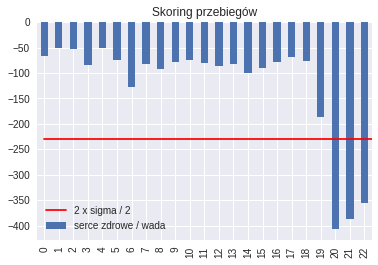

In [57]:
fa.score_samples(X_test).plot('bar'); plt.plot([(fa.score_samples(X_test).mean()-1.0*fa.score_samples(X_test).std())]*X_test.shape[1], 'r')
plt.legend(['2 x sigma / 2','serce zdrowe / wada'], loc='lower left'); plt.title('Skoring przebiegów')

Gęstość lokalna

In [58]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=5, contamination=0.1)
outliers = clf.fit_predict(X_test)

Text(0.5,1,'Wykrywanie outlierów / anomalii')

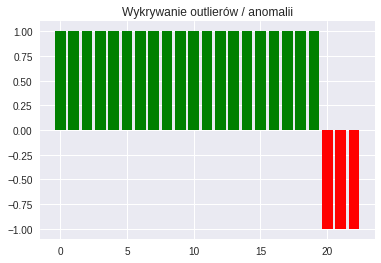

In [59]:
colors = [('r' if x==-1 else 'g') for x in outliers]
plt.bar(range(len(outliers)), outliers, color=colors); plt.title('Wykrywanie outlierów / anomalii')

Las losowy

In [ ]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(n_estimators=20, max_samples='auto', contamination=0.1)
outliers = clf.fit_predict(X_test)

Text(0.5,1,'Wykrywanie outlierów / anomalii')

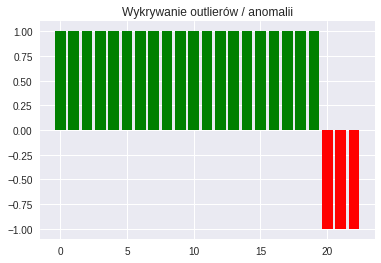

In [61]:
colors = [('r' if x==-1 else 'g') for x in outliers]
plt.bar(range(len(outliers)), outliers, color=colors); plt.title('Wykrywanie outlierów / anomalii')